# Project 3: AI Photo Editing with Inpainting  <a class="jp-toc-ignore"></a>

## Project Introduction <a class="jp-toc-ignore"></a>
In this project, you will build an interactive AI-powered photo editing application that combines state-of-the-art generative models for computer vision. The app enables users to swap the background of a subject in an image with a computer-generated scene described via text, or replace the subject itself while preserving the original background. This is achieved by integrating the Segment Anything Model (SAM) for precise object segmentation and a diffusion-based inpainting model for realistic image generation based on user prompts.

The challenge is to create an intuitive workflow where users can upload an image, select the main subject by clicking on it, and then use generative AI to transform either the background or the subject according to their creative vision. This project demonstrates the power of promptable segmentation and text-to-image diffusion models for creative and practical image manipulation tasks.

## Key Features of the Application <a class="jp-toc-ignore"></a>
- Interactive Subject Selection: Users upload an image and identify the primary object by clicking on it. The Segment Anything Model (SAM) generates a segmentation mask around the selected subject, which can be refined interactively for greater accuracy.
- Flexible Mask Refinement: The app allows users to accept or further refine the generated mask by adding more points, ensuring precise segmentation.
- Text-to-Image Generation: After finalizing the mask, users provide a text prompt (and optionally, a negative prompt) describing the desired new background or subject. The diffusion inpainting model uses this prompt to generate a realistic replacement.
- Background or Subject Substitution: Users can choose to either swap out the background while keeping the subject, or invert the mask to replace the subject and retain the background.
- Versatile Image Editing: The app supports background substitution, subject substitution, object removal, and creative compositing, making it suitable for a variety of image editing needs.

## Project Structure <a class="jp-toc-ignore"></a>
The current project is broken into the following parts:

1. **Loading and Running SAM:** Load the Segment Anything Model, process user input points, and generate segmentation masks.
2. **Mask Visualization and Refinement:** Visualize the generated mask and allow user-driven refinement for improved accuracy.
3. **Text-to-Image Inpainting:** Load and configure the diffusion inpainting model, process the mask and user prompts, and generate the new background or subject.
4. **Interactive Application:** Integrate all components into an interactive web app using Gradio, enabling users to upload images, select objects, enter prompts, and view results in real time.

In this project we will build a nice web app that allows you to swap out the background of a subject and substitute it with an image generated by Stable Diffusion through a text prompt:

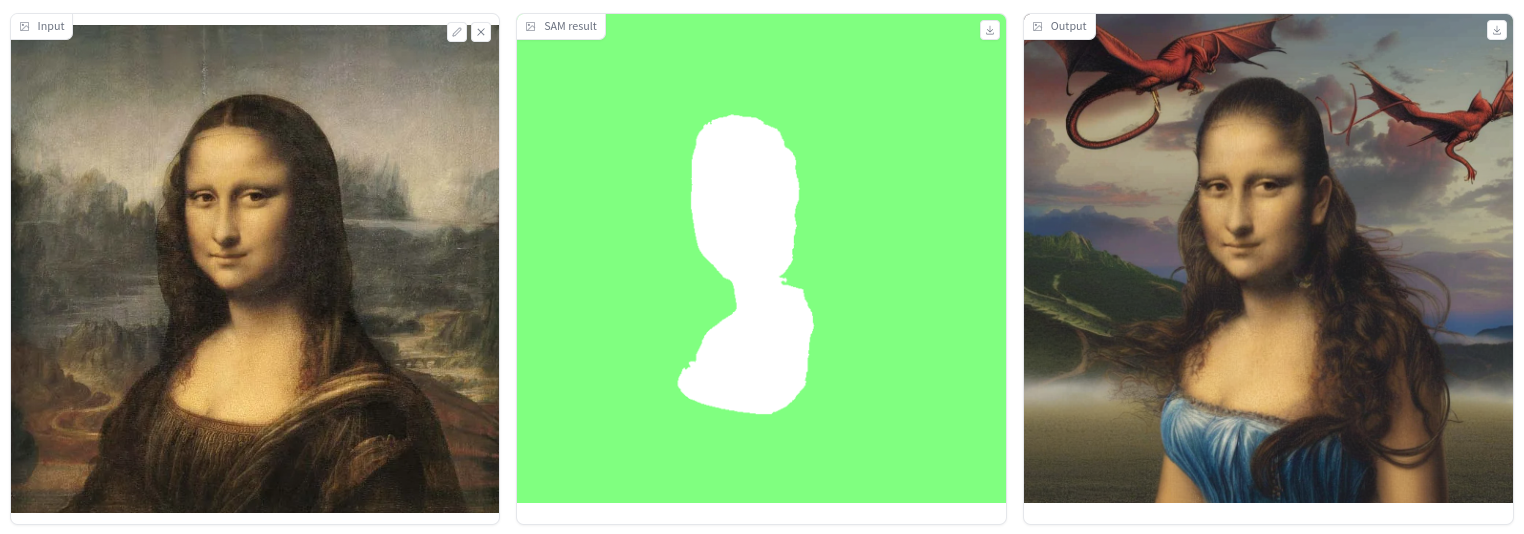

Let's start by importing what we need:

In [2]:
from PIL import Image
import requests
from transformers import SamModel, SamProcessor
from diffusers import DiffusionPipeline, AutoPipelineForText2Image, AutoPipelineForInpainting
from diffusers.utils import load_image, make_image_grid

import torch
import numpy as np

# Loading and Running SAM

Complete the following cell by loading the pretrained SAM from Facebook/Meta. Remember to:

1. Move the model to the GPU by adding `.to("cuda")`
2. Add the option `torch_dtype=torch.float16` to your call of AutoPipelineForInpainting.from_pretrained

This cell might take a couple of minutes to load.

In [3]:
# Load the SAM model as we have seen in the class
# Remeber to load it on the GPU by adding .to("cuda")
# at the end
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [6]:
model_version="facebook/sam-vit-base"

model = SamModel.from_pretrained(model_version).to(device)  # YOUR CODE HERE

# Load the SamProcessor using the facebook/sam-vit-base
# checkpoint
processor = SamProcessor.from_pretrained(model_version) # YOUR CODE HERE

# Mask Visualization and Refinement
Now that you have loaded SAM, complete the following function that uses SAM to produce a segmentation mask:

In [7]:
def mask_to_rgb(mask):
    """
    Transforms a binary mask into an RGBA image for visualization
    """
    
    bg_transparent = np.zeros(mask.shape + (4, ), dtype=np.uint8)
    
    # Color the area we will replace in green
    # (this vector is [Red, Green, Blue, Alpha])
    bg_transparent[mask == 1] = [0, 255, 0, 127]
    
    return bg_transparent



def get_processed_inputs(image, input_points):

    # Use the processor to generate the right inputs
    # for SAM
    # Use "image" as your image
    # Use 'input_points' as your input_points,
    # and remember to use the option return_tensors='pt'
    # Also, remember to add .to("cuda") at the end
    inputs = processor(images=image, input_points=input_points, return_tensors="pt").to(device) # YOUR CODE HERE

    # Call SAM
    outputs = model(**inputs)# YOUR CODE HERE

    # Now let's post process the outputs of SAM to obtain the masks
    masks = processor.image_processor.post_process_masks(
       outputs.pred_masks.cpu(),
       inputs["original_sizes"].cpu(),
       inputs["reshaped_input_sizes"].cpu()
    )

    # Here we select the mask with the highest score
    # as the mask we will use. You can experiment with also
    # other selection criteria, for example the largest mask
    # instead of the most confident mask
    best_mask = masks[0][0][outputs.iou_scores.argmax()]

    # NOTE: we invert the mask by using the ~ operator because
    # so that the subject pixels will have a value of 0 and the
    # background pixels a value of 1. This will make it more convenient
    # to infill the background
    return ~best_mask.cpu().numpy()

Now let's test what we have done so far. By executing this cell you should get a visualization of the mask for the following car:

<img src='car.png' width="200px"></img>

Let's see what happens in this cell:
1. We open the image of the car and **we resize it to 512 by 512 pixels** (a square image). This makes things simpler for this project
2. We define a few points on the image that indicate where the car is
3. We use the function we have defined to generate a mask using SAM
4. We visualize the mask

The mask should look like this:

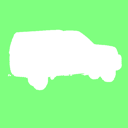

If it doesn't or you get errors, double check the code you have completed above and fix it before moving on.

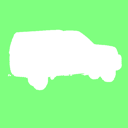

In [8]:
raw_image = Image.open("car.png").convert("RGB").resize((512, 512))

# These are the coordinates of two points on the car
input_points = [[[150, 170], [300, 250]]]

mask = get_processed_inputs(raw_image, input_points)

Image.fromarray(mask_to_rgb(mask)).resize((128, 128))

## Inpainting

Now that we have completed the SAM setup, let's move to the inpainting setup.

Let's start by loading our inpainting pipeline. We will use the `diffusers/stable-diffusion-xl-1.0-inpainting-0.1` pretrained model and the `AutoPipelineForInpainting` as we have seen in our `diffusers` demo in Lesson 5.

Complete the following code and run it (it might take a few minutes to run):

> **NOTE**: you will probably see a warning similar to ``The config attributes {'decay'...``. Please ignore it. It is a warning generated by the diffusers library that does not constitute a problem for our application

In [9]:
diffuser_version="diffusers/stable-diffusion-xl-1.0-inpainting-0.1"

In [10]:
# Load the AutoPipelineForInpainting pipeline
# (remember the diffusers demo in lesson 5)
# The checkpoint we want to use is
# "diffusers/stable-diffusion-xl-1.0-inpainting-0.1"
# Remember to add torch_dtype=torch.float16 as an option

pipeline = AutoPipelineForInpainting.from_pretrained(
    diffuser_version,
    torch_dtype=torch.float16
    ) # YOUR CODE HERE

# This will make it more efficient on our hardware
pipeline.enable_model_cpu_offload()

model_index.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

text_encoder_2/model.safetensors:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.93k [00:00<?, ?B/s]

tokenizer_2/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/10.3G [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer_2/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 37000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


Now complete the following function that gets in input:
1. The raw image
2. The mask generated by SAM (a numpy array)
3. The text prompt for the infill
4. An optional negative prompt
5. An optional seed for repeatibility
6. The Classifier-Free Guidance Scale (CFGS). If you don't remember what this is, refer to the Text Conditioning explanation in Lesson 5

In [11]:
def inpaint(
    raw_image, 
    input_mask, 
    prompt, 
    negative_prompt=None, 
    seed=74294536, 
    cfgs=7
):

    mask_image = Image.fromarray(input_mask)

    rand_gen = torch.manual_seed(seed)

    # Use the pipeline we have created in the previous cell
    # Use "prompt" as prompt,
    # "negative_prompt" as the negative prompt,
    # raw_image as the image,
    # mask_image as the mask_image,
    # rand_gen as the generator and
    # cfgs as the guidance_scale

    image = pipeline(
        image=raw_image,
        prompt=prompt,
        negative_prompt=negative_prompt,
        mask_image=mask_image,
        guidance_scale=cfgs,
        generator=rand_gen
    ).images[0]

    return image



Let's test our inpainting on the mask we have obtained earlier with SAM:

In [12]:
prompt = "a car driving on Mars. Studio lights, 1970s"
negative_prompt = "artifacts, low quality, distortion"

image = inpaint(raw_image, mask, prompt, negative_prompt)

  0%|          | 0/49 [00:00<?, ?it/s]

Let's have a look at what we have produced:

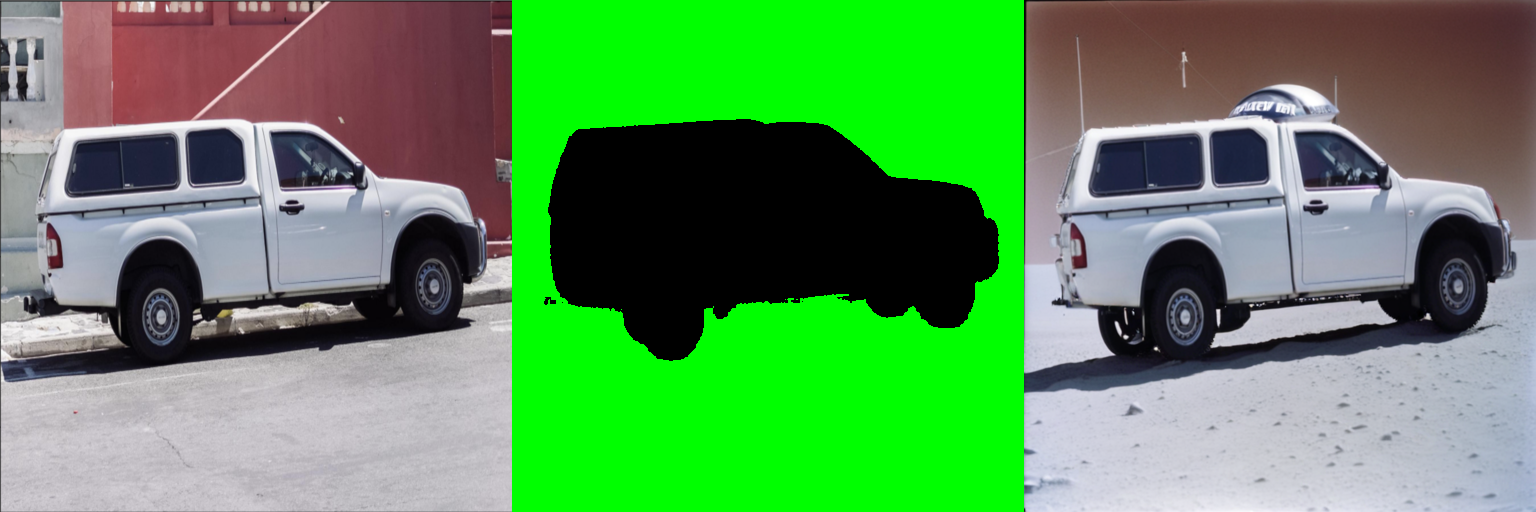

In [13]:
fig = make_image_grid([raw_image, Image.fromarray(mask_to_rgb(mask)), image.resize((512, 512))], rows=1, cols=3)
fig

## Interactive app

To make things a bit more fun, we have prepared an interactive app for you that uses the code you have completed and allow you to upload an image, run SAM, and generate the new background through a text prompt.

Simply execute the following cell. The output will contain a preview of the app: **DO NOT USE IT**. Instead, you will also see a link similar to this:

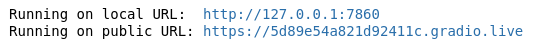

Click on the second link (the public URL), from there you will be able to use the app much more comfortably.

> NOTE: if for any reason you need to stop the app, click on the stop icon of the jupyter interface:   then **execute the next cell containing the code `my_app.close`**


In [13]:
import app

In [14]:
my_app = app.generate_app(get_processed_inputs, inpaint)

Running on local URL:  http://127.0.0.1:7860
IMPORTANT: You are using gradio version 3.50.2, however version 4.44.1 is available, please upgrade.
--------
Running on public URL: https://355b264a2b73abfc37.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


  0%|          | 0/49 [00:00<?, ?it/s]

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://355b264a2b73abfc37.gradio.live


In [16]:
my_app.close()

Closing server running on port: 7860
